<a href="https://colab.research.google.com/github/LamiaTasnim/neural_network_pytorch/blob/main/image_caption/image_caption_CNN_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
from pycocotools.coco import COCO
import urllib
import zipfile

os.makedirs('opt' , exist_ok=True)
## change directory
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 26.86 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [ ]:
os.chdir('/content/opt/cocoapi')

# Download the annotation :
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

('image_info_test2014.zip', <http.client.HTTPMessage at 0x7f735c8f4640>)

In [ ]:
## extract annotations from zipfile
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip removed')
except:
  None

zip removed
zip removed


In [ ]:
## initialize the loaded data
os.chdir('/content/opt/cocoapi/annotations')

# initialize COCO API for instance annotations
dataType = 'val2014'
instances_annFile = 'instances_{}.json'.format(dataType)
print(instances_annFile)
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = 'captions_{}.json'.format(dataType)
coco_caps = COCO(captions_annFile)

# get image ids
ids = list(coco.anns.keys())

instances_val2014.json
loading annotations into memory...
Done (t=9.57s)
creating index...
index created!
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


http://images.cocodataset.org/val2014/COCO_val2014_000000400719.jpg
Number of annotations i.e captions for the image:  [635556, 641544, 643659, 644826, 646446]

A group of people in a city park many are flying kites.
a group of people watching kites in the sky
Scattered kites dot the sky above a field filled with people.
A park with several people in it and kites in the sky.
A crowd of people flying kites with a city skyline in the background.


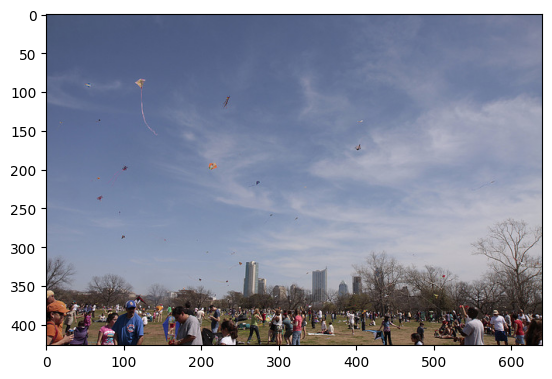

In [ ]:
# plot an image
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
%matplotlib inline

#Pick a random annotation id and display img of that annotation  :
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']
print(url)
I = io.imread(url)
plt.imshow(I)

# Display captions for that annotation id :
ann_ids = coco_caps.getAnnIds(img_id)
print('Number of annotations i.e captions for the image: ', ann_ids)
print()
anns = coco_caps.loadAnns(ann_ids)
coco_caps.showAnns(anns)

In [ ]:
# download train, test images
os.chdir('/content/opt/cocoapi')

train2014 = 'http://images.cocodataset.org/zips/train2014.zip'
test2014 = 'http://images.cocodataset.org/zips/test2014.zip'
val2014 = 'http://images.cocodataset.org/zips/val2014.zip'

urllib.request.urlretrieve( train2014 , 'train2014' )
urllib.request.urlretrieve( test2014 , 'test2014' )
#urllib.request.urlretrieve( val2014 , 'val2014' )

('test2014', <http.client.HTTPMessage at 0x7f731d5c82b0>)

In [ ]:
# unzip the downloaded images zip file
os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'train2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'train2014' )
  print('zip removed')
except:
  None

os.chdir('/content/opt/cocoapi')
with zipfile.ZipFile( 'test2014' , 'r' ) as zip_ref:
  zip_ref.extractall( 'images' )

try:
  os.remove( 'test2014' )
  print('zip removed')
except:
  None

zip removed
zip removed


In [ ]:
# vocabulary.py -------------------------------------------------------------
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="",
        end_word="",
        unk_word="",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False
        ):

        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            ## wb: write binary. vocab_file is the file you want to create.
            ## dump() store the object data to the file
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)

    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
# Data Loader ---------------------------------------------------------------------------------------------

import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="",
               end_word="",
               unk_word="",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc='/opt'
               ):
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)
    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset,
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):

    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word,
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]

    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)


In [ ]:
import sys
from pycocotools.coco import COCO
!pip install nltk
import nltk
nltk.download('punkt')
from torchvision import transforms


# Define a transform to pre-process the training images.
transform_train = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 8

# Specify the batch size.
batch_size = 200

# Obtain the data loader.
data_loader_train = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         cocoapi_loc = '/content/opt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


loading annotations into memory...
Done (t=1.49s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=1.41s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 414113/414113 [01:04<00:00, 6403.36it/s]


In [ ]:
import torch
import numpy as np
import torch.utils.data as data

# Exploring the dataloader now :
sample_caption = 'A person doing a trick xxxx on a rail while riding a skateboard.'
sample_tokens = nltk.tokenize.word_tokenize( sample_caption.lower() )

sample_caption = []
start_word  = data_loader_train.dataset.vocab.start_word
end_word = data_loader_train.dataset.vocab.end_word
sample_tokens.insert(0 , start_word)
sample_tokens.append(end_word)
sample_caption.extend( [ data_loader_train.dataset.vocab(token) for token in sample_tokens ] )


sample_caption = torch.Tensor( sample_caption ).long()
print('Find Below the Sample tokens and the idx values of those tokens in word2idx' , '\n')
print(sample_tokens)
print(sample_caption )

print('Find index values for words below \n')
print('Start idx {} , End idx {} , unknown idx {}'.format( 0,1,2 ))

Find Below the Sample tokens and the idx values of those tokens in word2idx 

['', 'a', 'person', 'doing', 'a', 'trick', 'xxxx', 'on', 'a', 'rail', 'while', 'riding', 'a', 'skateboard', '.', '']
tensor([  0,   1,  95, 742,   1, 391,   0,  36,   1, 991, 203, 135,   1, 741,
         16,   0])
Find index values for words below 

Start idx 0 , End idx 1 , unknown idx 2


The captions in the dataset vary greatly in length. You can see this by examining data_loader.dataset.caption_lengths, a Python list with one entry for each training caption length.
In the code cell below, we use this list to print the total number of captions in the training data with each length. As you will see below, the majority of captions have length 10. Likewise, very short and very long captions are quite rare.

In [ ]:
from collections import Counter

counter = Counter(data_loader_train.dataset.caption_lengths)
lengths = sorted( counter.items() , key = lambda pair : pair[1] , reverse=True )
for val,count in lengths:
  print( 'value %2d  count %5d' %(val,count) )
  if count < 10000:
    break

value 10  count 86302
value 11  count 79971
value  9  count 71920
value 12  count 57653
value 13  count 37668
value 14  count 22342
value  8  count 20742
value 15  count 12839
value 16  count  7736


To generate batches of training data, we begin by first sampling a caption length (where the probability that any length is drawn is proportional to the number of captions with that length in the dataset). Then, we retrieve a batch of size batch_size of image-caption pairs, where all captions have the sampled length. This approach for assembling batches matches the procedure in this paper and has been shown to be computationally efficient without degrading performance.


Run the code cell below to generate a batch. The get_train_indices method in the CoCoDataset class first samples a caption length, and then samples batch_size indices corresponding to training data points with captions of that length. These indices are stored below in indices.


These indices are supplied to the data loader, which then is used to retrieve the corresponding data points. The pre-processed images and captions in the batch are stored in images and captions.

In [ ]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader_train.dataset.get_train_indices()
print('Sample Indices:' , indices )

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
sampler = data.sampler.SubsetRandomSampler(  indices )
data_loader_train.batch_sampler.sampler = sampler

# obtain images, caption :
images , captions = next(iter(data_loader_train))
print(images.shape , captions.shape)

Sample Indices: [78350, 350106, 130048, 294797, 397585, 96306, 358461, 174127, 94823, 352254, 131555, 15205, 89444, 36955, 176236, 80892, 339660, 291095, 95132, 260338, 304177, 403332, 199361, 55157, 49864, 374299, 341320, 20028, 374987, 380007, 344477, 136519, 321479, 96581, 7423, 2814, 307667, 62060, 171646, 154726, 28422, 18884, 79360, 150294, 73458, 82095, 25200, 350122, 241690, 368826, 174175, 166416, 326771, 19807, 205754, 393131, 126896, 330701, 43445, 52183, 206032, 257967, 127072, 160693, 267989, 364814, 342055, 41643, 294477, 135153, 163791, 129713, 330439, 148403, 323466, 344657, 261644, 143448, 5887, 111703, 8352, 194104, 296801, 275147, 10442, 391912, 109378, 129574, 59636, 160637, 133026, 400335, 353650, 27912, 184553, 109055, 41216, 175846, 249608, 120145, 227168, 278817, 227536, 249400, 220550, 281824, 134479, 373614, 3682, 138002, 234528, 109955, 50591, 39390, 189665, 141322, 368437, 328951, 396099, 16234, 401336, 174037, 70727, 161056, 3144, 81144, 279839, 396701, 179

Experiment with the CNN Encoder

The encoder uses the pre-trained ResNet-50 architecture (with the final fully-connected layer removed) to extract features from a batch of pre-processed images. The output is then flattened to a vector, before being passed through a Linear layer to transform the feature vector to have the same size as the word embedding.

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        # disable learning for parameters
        for param in resnet.parameters():
            param.requires_grad_(False)

        # fully connected layer removed
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        ## transfer the feature vector to have the same size as word embedding
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        ## flattening the features
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features

In [ ]:
# specify dim of image embedding
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_size = 256
encoder = EncoderCNN( embed_size )
encoder.to(device)
images=  images.to(device) # images from step2
features = encoder(images)

print(type(features) , features.shape , images.shape)
assert( type(features) == torch.Tensor )  , 'Encoder output should be pytorch tensor'
assert (features.shape[0] == batch_size) & (features.shape[1] == embed_size)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 86.7MB/s]


<class 'torch.Tensor'> torch.Size([200, 256]) torch.Size([200, 3, 224, 224])


Implement the RNN Decoder

In the code cell below, outputs should be a PyTorch tensor with size [batch_size, captions.shape[1], vocab_size]. Your output should be designed such that outputs[i,j,k] contains the model's predicted score, indicating how likely the j-th token in the i-th caption in the batch is the k-th token in the vocabulary.

In [ ]:
import os
import torch.utils.data as data
import torch
import math
import pickle
import matplotlib.pyplot as plt
#% matplotlib inline

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
      super( DecoderRNN , self).__init__()
      ## embed size: final embedding size of the cnn encoder
      self.embed_size = embed_size
      self.hidden_size = hidden_size
      self.vocab_size = vocab_size
      self.num_layers = num_layers
      self.word_embedding = nn.Embedding( self.vocab_size , self.embed_size )
      self.lstm  = nn.LSTM(input_size = self.embed_size ,
                            hidden_size = self.hidden_size,
                            num_layers  = self.num_layers ,
                            batch_first = True
                            )
      self.fc = nn.Linear(self.hidden_size , self.vocab_size)


    def init_hidden( self, batch_size ):
      return ( torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device),
      torch.zeros( self.num_layers , batch_size , self.hidden_size  ).to(device) )

    def forward(self, features, captions):
      ## features: features tensor. shape is (batch_size, embed_size)
      ## captions: captions tensor. shape is (batch_size, cap_length)
      ## remove <end> token from captions
      captions = captions[:,:-1]  ## caption size: (batch_size, cap_length-1, embed_size)
      self.batch_size = features.shape[0]
      self.hidden = self.init_hidden(self.batch_size)
      embeds = self.word_embedding(captions)
      # cat(): concatanate 2 tensors along the dim=1(y axis).
      # (batch_size, 1, embed_size) concat (batch_size, cap_length-1, embed_size) => (batch_size, cap_length, embed_size)
      inputs = torch.cat((features.unsqueeze(dim=1), embeds), dim =1)
      # lstm_out: all the hidden states, hidden: most recent hidden state
      lstm_out , self.hidden = self.lstm(inputs , self.hidden)  # (bs, cap_length, hidden_size), (1, bs, hidden_size)
      outputs = self.fc(lstm_out)  # (bs, cap_length, vocab_size)
      return outputs

    def Predict(self, inputs, max_len=20):
      # accepts pre-processed image tensor (inputs) and returns predicted
      # sentence (list of tensor ids of length max_len)
      final_output = []
      batch_size = inputs.shape[0]
      hidden = self.init_hidden(batch_size)

      while True:
          lstm_out, hidden = self.lstm(inputs, hidden)
          outputs = self.fc(lstm_out)
          outputs = outputs.squeeze(1)
          _, max_idx = torch.max(outputs, dim=1) # max_idx: (1,1)
          final_output.append(max_idx.cpu().numpy()[0].item())
          ## max_idx = 1 means stop
          if (max_idx == 1 or len(final_output) >=20 ):
              break

          inputs = self.word_embedding(max_idx) ## inputs: (1, embed_size)
          inputs = inputs.unsqueeze(1) ## inputs: (1,1, embed_size)
      return final_output

In [ ]:
embed_size = 256
hidden_size = 100
num_layers =1
num_epochs = 4
print_every = 150
save_every = 1
vocab_size = len(data_loader_train.dataset.vocab)
total_step = math.ceil(len(data_loader_train.dataset.caption_lengths) / data_loader_train.batch_sampler.batch_size)

decoder = DecoderRNN(embed_size , hidden_size, vocab_size ,num_layers)
criterion = nn.CrossEntropyLoss()
lr = 0.001
all_params = list(decoder.parameters())  + list(encoder.embed.parameters())
optimizer = torch.optim.Adam(params= all_params , lr = lr)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = '/content/drive/MyDrive/pytorchLearning'
os.makedirs( model_save_path , exist_ok=True)

# Save the params needed to created the model :
decoder_input_params = {'embed_size' : embed_size ,
                'hidden_size' : hidden_size ,
                'num_layers' : num_layers,
                'lr' : lr ,
                'vocab_size' : vocab_size
                }

with open(os.path.join(model_save_path, 'decoder_input_params_12_20_2019.pickle'), 'wb') as handle:
    pickle.dump(decoder_input_params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import sys
for e in range(num_epochs):
  for step in range(total_step):
    indices = data_loader_train.dataset.get_train_indices()
    new_sampler = data.sampler.SubsetRandomSampler(indices)
    data_loader_train.batch_sampler.sampler = new_sampler
    images,captions = next(iter(data_loader_train))
    images , captions = images.to(device) , captions.to(device)
    encoder , decoder = encoder.to(device) , decoder.to(device)
    encoder.zero_grad()
    decoder.zero_grad()
    features = encoder(images)
    output = decoder(features , captions)
    loss = criterion(output.view(-1, vocab_size) , captions.view(-1))
    loss.backward()
    optimizer.step()
    stat_vals = 'Epochs [%d/%d] Step [%d/%d] Loss [%.4f] ' %( e+1,num_epochs,step,total_step,loss.item() )
    if step % print_every == 0 :
      print(stat_vals)
      sys.stdout.flush()
    if e % save_every == 0:
      torch.save( encoder.state_dict() ,  os.path.join( model_save_path , 'encoderdata_{}.pkl'.format(e+1) ) )
      torch.save( decoder.state_dict() ,  os.path.join( model_save_path , 'decoderdata_{}.pkl'.format(e+1) ) )

Epochs [1/4] Step [0/2071] Loss [8.8741] 
Epochs [1/4] Step [150/2071] Loss [4.1113] 


In [ ]:
# load the saved checkpoints
model_save_path = '/content/drive/MyDrive/pytorchLearning'
os.makedirs(model_save_path , exist_ok=True)
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(os.path.join(model_save_path , 'decoder_input_params_12_19_2019.pickle'), 'rb') as handle:
    decoder_input_params = pickle.load(handle)

embed_size = decoder_input_params['embed_size']
hidden_size= decoder_input_params['hidden_size']
vocab_size = decoder_input_params['vocab_size']
num_layers = decoder_input_params['num_layers']

encoder = EncoderCNN(embed_size)
encoder.load_state_dict(torch.load(os.path.join(model_save_path , 'encoderdata_{}.pkl'.format(1))))

decoder = DecoderRNN(embed_size , hidden_size , vocab_size , num_layers)
decoder.load_state_dict( torch.load(os.path.join(model_save_path , 'decoderdata_{}.pkl'.format(1))))

In [ ]:
# create dataloader for test data
from torchvision import transforms

# Define atransform to pre-process the training images.
transform_test = transforms.Compose([
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Obtain the data loader.
data_loader_test = get_loader(transform=transform_test,
                         mode='test',
                         cocoapi_loc = '/content/opt')
data_iter = iter(data_loader_test)

In [ ]:
def get_sentences(original_img, all_predictions):
  sentence = ' '
  plt.imshow(original_img.squeeze())
  return sentence.join([data_loader_test.dataset.vocab.idx2word[idx] for idx in all_predictions[1:-1]])

encoder.to(device)
decoder.to(device)
encoder.eval()
decoder.eval()
original_img , processed_img  = next(data_iter)

features  = encoder(processed_img.to(device)).unsqueeze(1)
final_output = decoder.predict(features, max_len=20)
get_sentences(original_img, final_output)